# *Traffic Sign Recognizer - 99% accuracy*

## Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

## Assigning Path for Dataset

In [2]:
data_dir = '../input/gtsrb-german-traffic-sign'
train_path = '../input/gtsrb-german-traffic-sign/Train'
test_path = '../input/gtsrb-german-traffic-sign/'
étiquettes = '../input/gtsrbgermantrafficsign/tiquette.csv'

# Resizing the images to 32x32x3
IMG_HEIGHT = 32
IMG_WIDTH = 32
channels = 3

## Finding Total Classes

In [3]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [4]:
# Label Overview
data = pd.read_csv(étiquettes)
classes = data["Sign"]
print(classes)

0                                  Speed limit (20km/h)
1                                  Speed limit (30km/h)
2                                  Speed limit (50km/h)
3                                  Speed limit (60km/h)
4                                  Speed limit (70km/h)
5                                  Speed limit (80km/h)
6                           End of speed limit (80km/h)
7                                 Speed limit (100km/h)
8                                 Speed limit (120km/h)
9                                            No passing
10         No passing for vechiles over 3.5 metric tons
11                Right-of-way at the next intersection
12                                        Priority road
13                                                Yield
14                                                 Stop
15                                          No vechiles
16             Vechiles over 3.5 metric tons prohibited
17                                             N

In [5]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Visualizing The Dataset

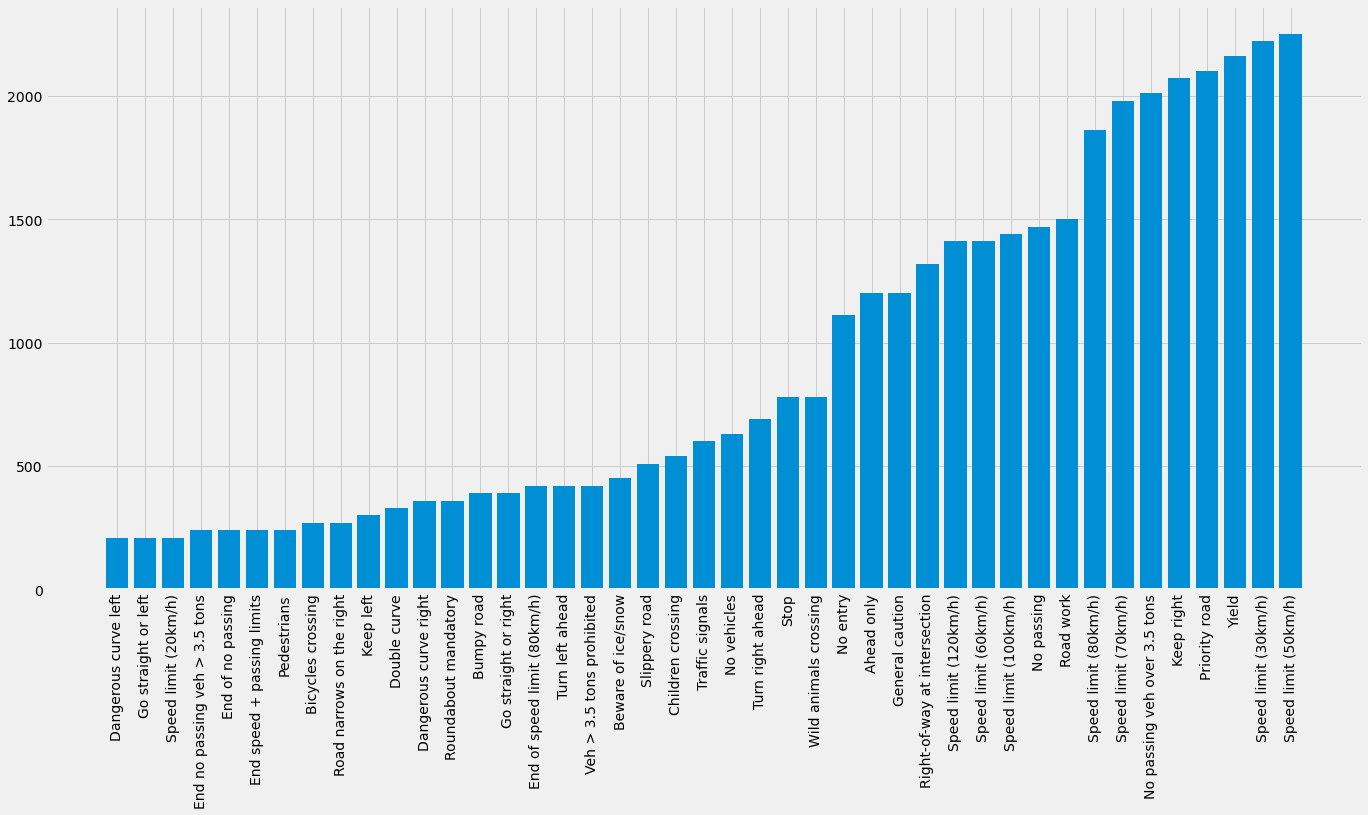

In [6]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

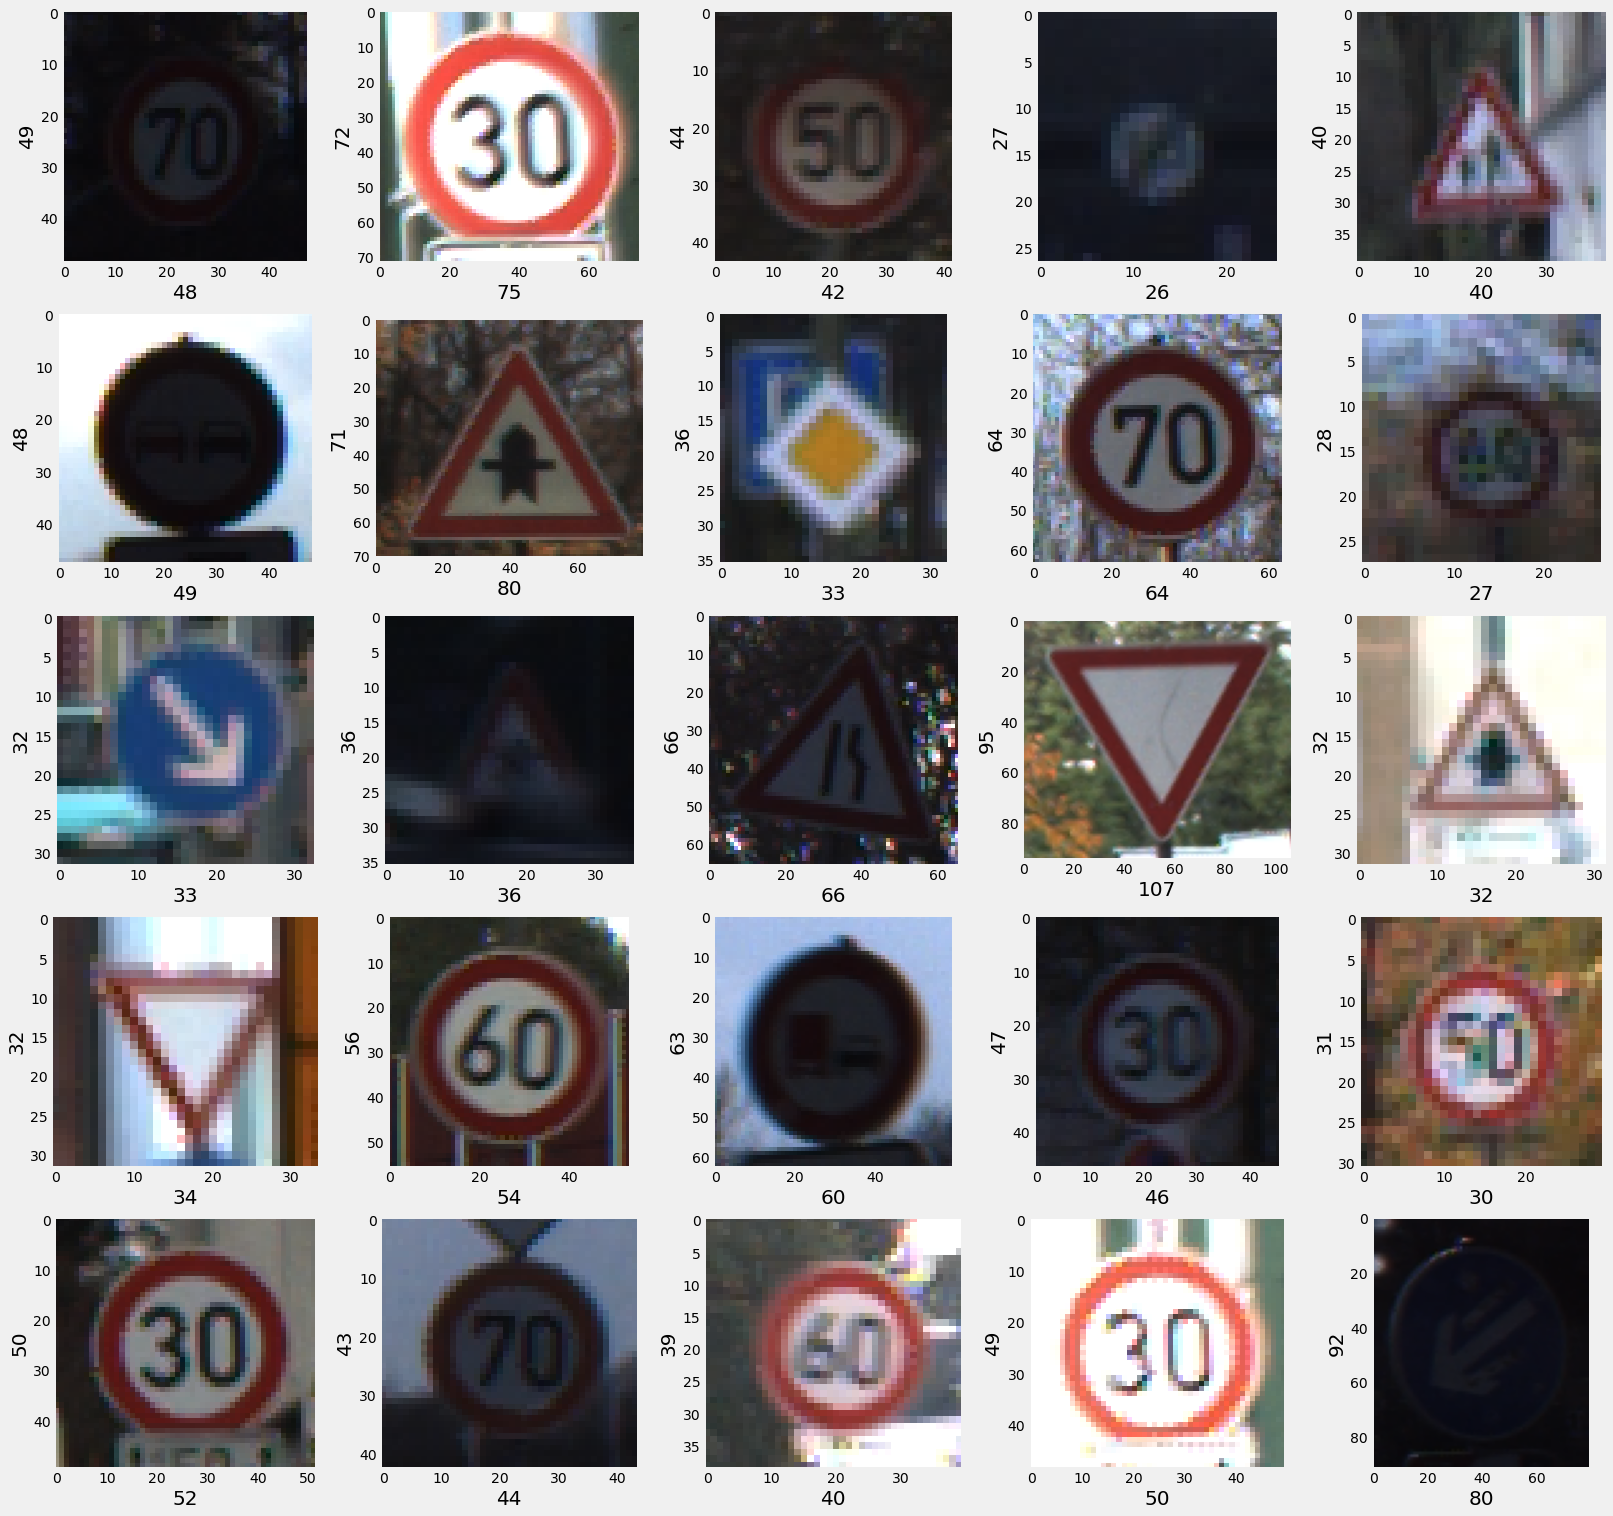

In [7]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

## Collecting the Training Data

In [8]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            resize_image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH)) 
            image_data.append(resize_image)
            image_labels.append(i)
        except:
            print("Error in " + img)
# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 32, 32, 3) (39209,)


## Loading the test data

In [9]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        resize_image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
        data.append(resize_image)
    except:
        print("Error in " + img)
X_test = np.array(data)
print(X_test.shape, labels.shape)


(12630, 32, 32, 3) (12630,)


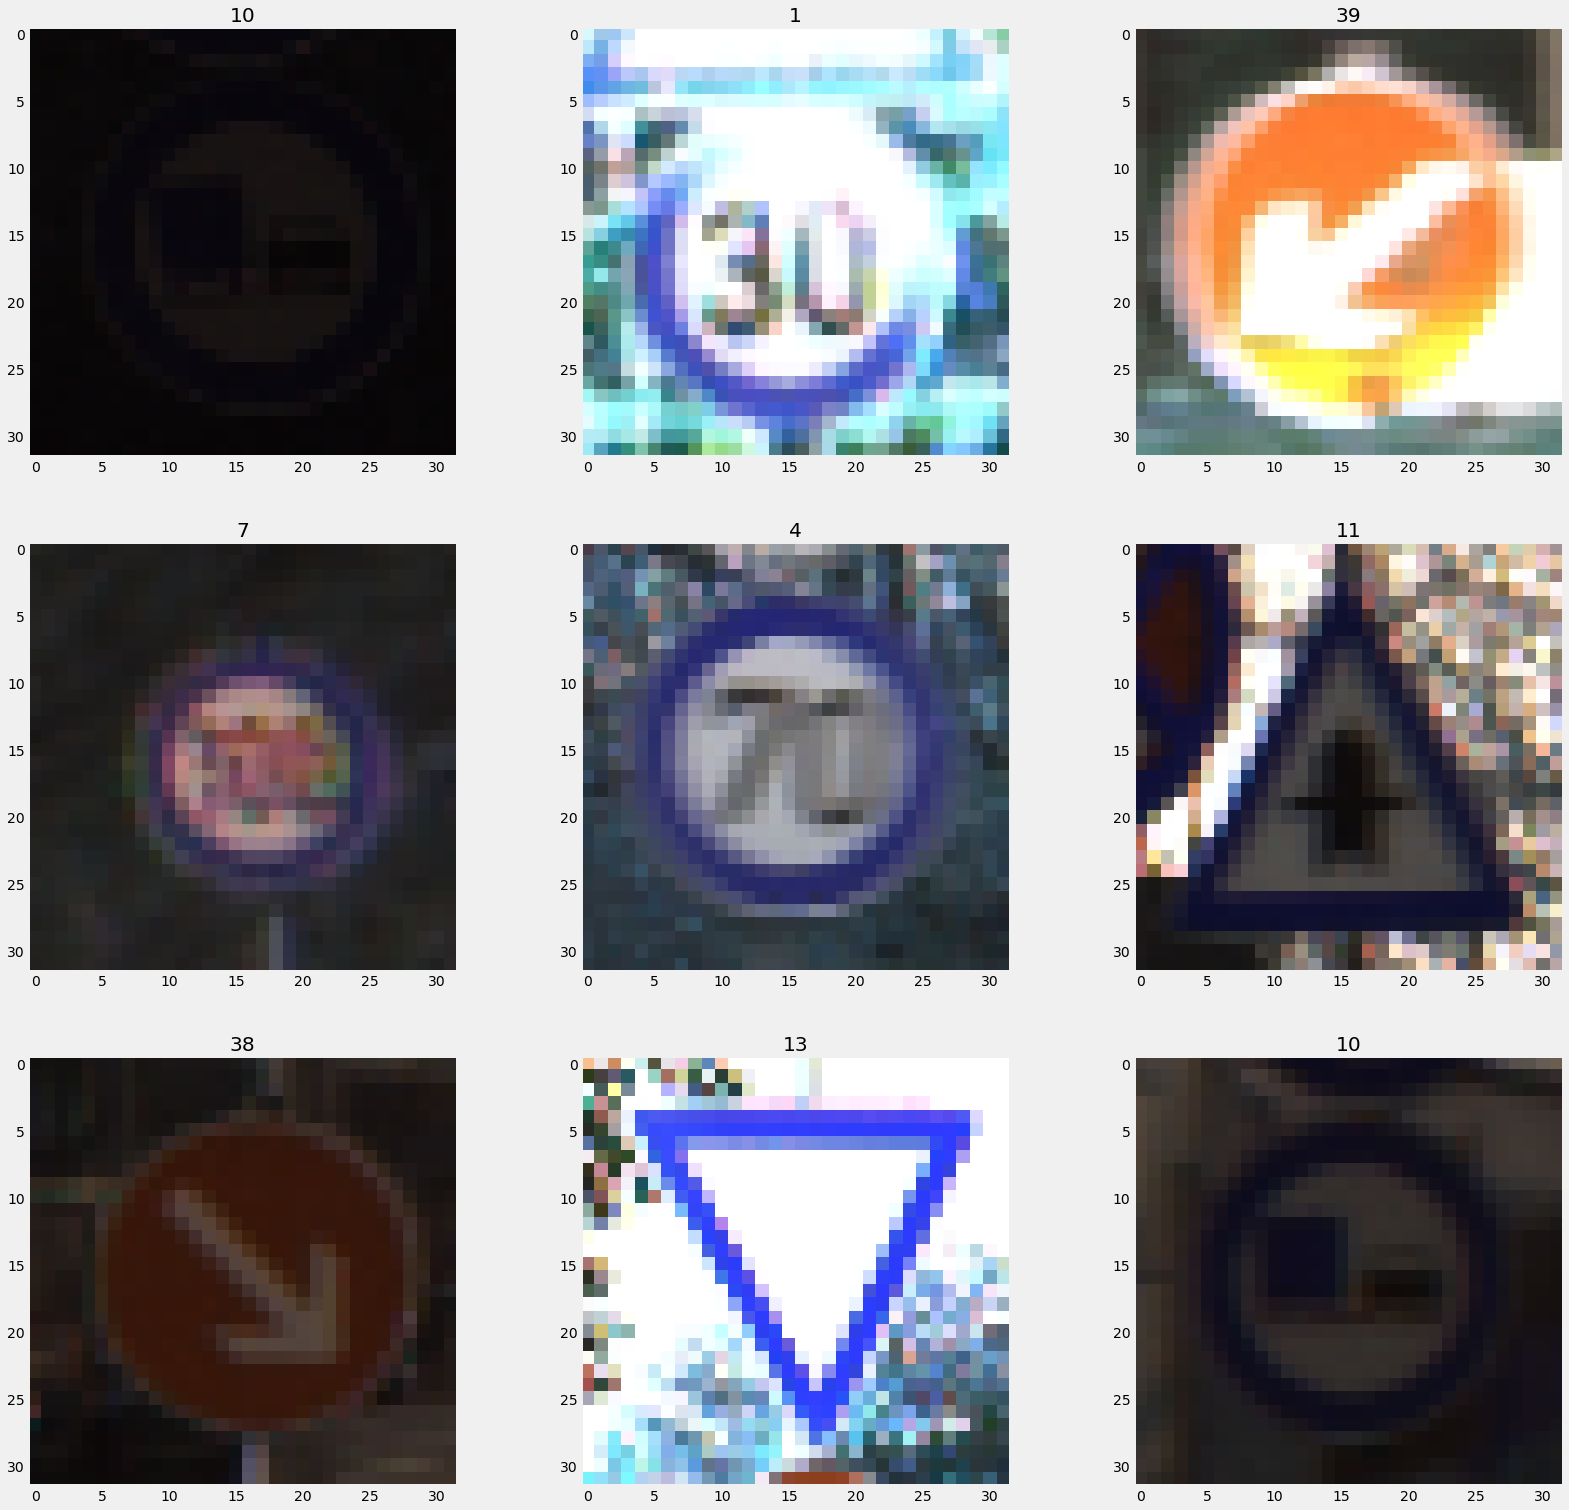

In [10]:
plt.figure(figsize=(25,25))
for i in range(1,10):
   
    plt.subplot(3,3,i)
    j = np.random.randint(image_data.shape[0])
    plt.imshow(image_data[j])
    plt.title(image_labels[j]) 
    plt.grid(b=None)

plt.show()

## Shuffling the training data

In [11]:
shuffle_indexes = np.arange(image_data.shape[0])
print(shuffle_indexes)
np.random.shuffle(shuffle_indexes)
print(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]


[    0     1     2 ... 39206 39207 39208]
[ 4672 34793 37500 ...  2433   769  1685]


## Splitting the data into train and validation set

In [12]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.1, random_state=42, shuffle=True)

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (35288, 32, 32, 3)
X_valid.shape (3921, 32, 32, 3)
y_train.shape (35288,)
y_valid.shape (3921,)


## Data preprocessing using OpenCV

In [13]:
def preprocessing(img): 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    img = cv2.equalizeHist(img) 
    img = img / 255
    return img 
  
X_train = np.array(list(map(preprocessing, X_train))) 
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test))) 

print(X_train.shape) 
print(X_val.shape) 
print(X_test.shape) 

(35288, 32, 32)
(3921, 32, 32)
(12630, 32, 32)


In [14]:
X_train = X_train.reshape(35288, 32, 32, 1) 
X_val = X_val.reshape(3921, 32, 32, 1) 
X_test = X_test.reshape(12630, 32, 32, 1) 


## One hot encoding the labels

In [15]:
print(y_train[0])
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)
y_test = keras.utils.to_categorical(labels, NUM_CATEGORIES)
print(y_train.shape)
print(y_val.shape)
print(y_train[0])

16
(35288, 43)
(3921, 43)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Making the model

In [16]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,1)),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),
  
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    #keras.layers.Dropout(rate=0.3),
    
    keras.layers.Dense(43, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0

In [17]:
lr = 0.0001
epochs = 10
#, decay=lr / (epochs * 0.5)
opt = Adam(lr=lr)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Augmenting the data 

In [18]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")
#aug.fit(X_train)
#aug.fit(X_val)

## Training the model

In [19]:
#history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/10
1103/1103 [==============================] - 5s 5ms/step - loss: 0.5024 - accuracy: 0.8768 - val_loss: 0.1460 - val_accuracy: 0.9645
Epoch 2/10
1103/1103 [==============================] - 5s 5ms/step - loss: 0.0524 - accuracy: 0.9901 - val_loss: 0.0884 - val_accuracy: 0.9760
Epoch 3/10
1103/1103 [==============================] - 5s 5ms/step - loss: 0.0155 - accuracy: 0.9983 - val_loss: 0.0621 - val_accuracy: 0.9806
Epoch 4/10
1103/1103 [==============================] - 5s 4ms/step - loss: 0.0120 - accuracy: 0.9978 - val_loss: 0.0487 - val_accuracy: 0.9860
Epoch 5/10
1103/1103 [==============================] - 5s 5ms/step - loss: 0.0072 - accuracy: 0.9990 - val_loss: 0.0434 - val_accuracy: 0.9875
Epoch 6/10
1103/1103 [==============================] - 5s 4ms/step - loss: 0.0075 - accuracy: 0.9985 - val_loss: 0.0397 - val_accuracy: 0.9880
Epoch 7/10
1103/1103 [==============================] - 5s 5ms/step - loss: 0.0067 - accuracy: 0.9988 - val_loss: 0.0323 - val_accuracy:

In [19]:
history = model.fit_generator(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=aug.flow(X_val, y_val, batch_size=8))

Epoch 1/10
1103/1103 [==============================] - 15s 13ms/step - loss: 1.3099 - accuracy: 0.6483 - val_loss: 0.6668 - val_accuracy: 0.8046
Epoch 2/10
1103/1103 [==============================] - 14s 13ms/step - loss: 0.4012 - accuracy: 0.8862 - val_loss: 0.3462 - val_accuracy: 0.9021
Epoch 3/10
1103/1103 [==============================] - 14s 13ms/step - loss: 0.2071 - accuracy: 0.9436 - val_loss: 0.2053 - val_accuracy: 0.9419
Epoch 4/10
1103/1103 [==============================] - 14s 13ms/step - loss: 0.1250 - accuracy: 0.9663 - val_loss: 0.1044 - val_accuracy: 0.9737
Epoch 5/10
1103/1103 [==============================] - 15s 13ms/step - loss: 0.0850 - accuracy: 0.9775 - val_loss: 0.1146 - val_accuracy: 0.9653
Epoch 6/10
1103/1103 [==============================] - 14s 13ms/step - loss: 0.0645 - accuracy: 0.9823 - val_loss: 0.0626 - val_accuracy: 0.9811
Epoch 7/10
1103/1103 [==============================] - 15s 13ms/step - loss: 0.0500 - accuracy: 0.9865 - val_loss: 0.1173 -

## Evaluating the model

In [20]:
print(np.mean(history.history['loss']))
print(np.mean(history.history['accuracy']))
print(np.mean(history.history['val_loss']))
print(np.mean(history.history['val_accuracy']))

0.23415676057338713
0.9363239526748657
0.17773626260459424
0.9489670991897583


Text(0.5, 0, 'epoch')

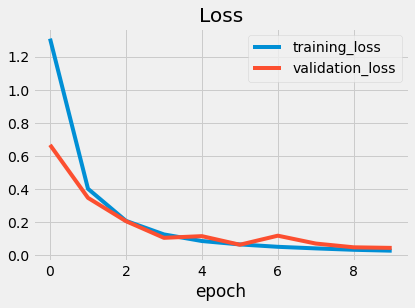

In [21]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.legend(['training_loss', 'validation_loss']) 
plt.title('Loss') 
plt.xlabel('epoch') 

Text(0.5, 0, 'epoch')

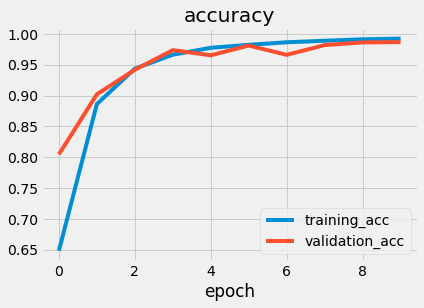

In [22]:
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.legend(['training_acc', 'validation_acc']) 
plt.title('accuracy') 
plt.xlabel('epoch') 

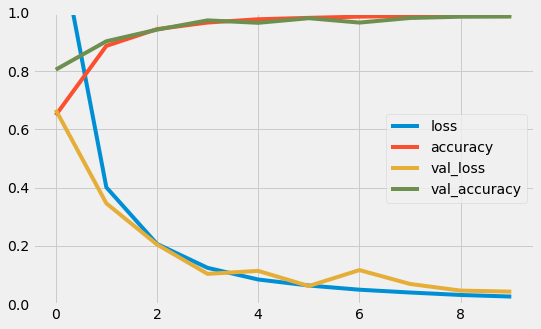

In [23]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Running the predictions

In [24]:
#pred = model.predict_classes(X_test)
predict_x=model.predict(X_test) 
print(predict_x.shape)
print(predict_x[0])
print(np.sum(predict_x,axis=1))
classes_x=np.argmax(predict_x,axis=1)
pred=classes_x
print(pred)
#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

(12630, 43)
[1.1647961e-08 3.8495221e-10 7.0167383e-10 8.7307450e-09 2.5061329e-09
 3.7503294e-09 3.5625984e-09 3.2082171e-06 1.1791464e-07 1.8170209e-05
 7.5362772e-07 1.7206124e-09 7.3922672e-09 2.0028825e-09 1.7619089e-06
 3.1210334e-07 9.9990118e-01 6.7321169e-05 2.6507727e-09 3.2260685e-09
 1.2413706e-10 1.2000784e-11 5.0519869e-08 5.7120073e-09 1.2771850e-10
 4.2649904e-11 1.4407451e-11 1.0335433e-09 4.5004720e-09 2.4694975e-08
 4.2475988e-12 7.8153137e-09 1.5088706e-07 2.7908609e-06 1.5839797e-07
 7.6342150e-09 1.0744368e-08 7.9783277e-08 2.0326254e-07 3.4937455e-07
 1.6507622e-06 4.6030001e-07 1.2249313e-06]
[1.0000001  1.         1.0000001  ... 1.         0.99999994 1.0000001 ]
[16  1 38 ...  3  7 10]
Test Data accuracy:  96.55581947743468


In [25]:
model.evaluate(X_test, y_test)

395/395 [==============================] - 1s 3ms/step - loss: 0.1225 - accuracy: 0.9656


[0.12246830016374588, 0.9655581712722778]

## Visualizing the confusion matrix

In [26]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

Text(93.7, 0.5, 'True Label')

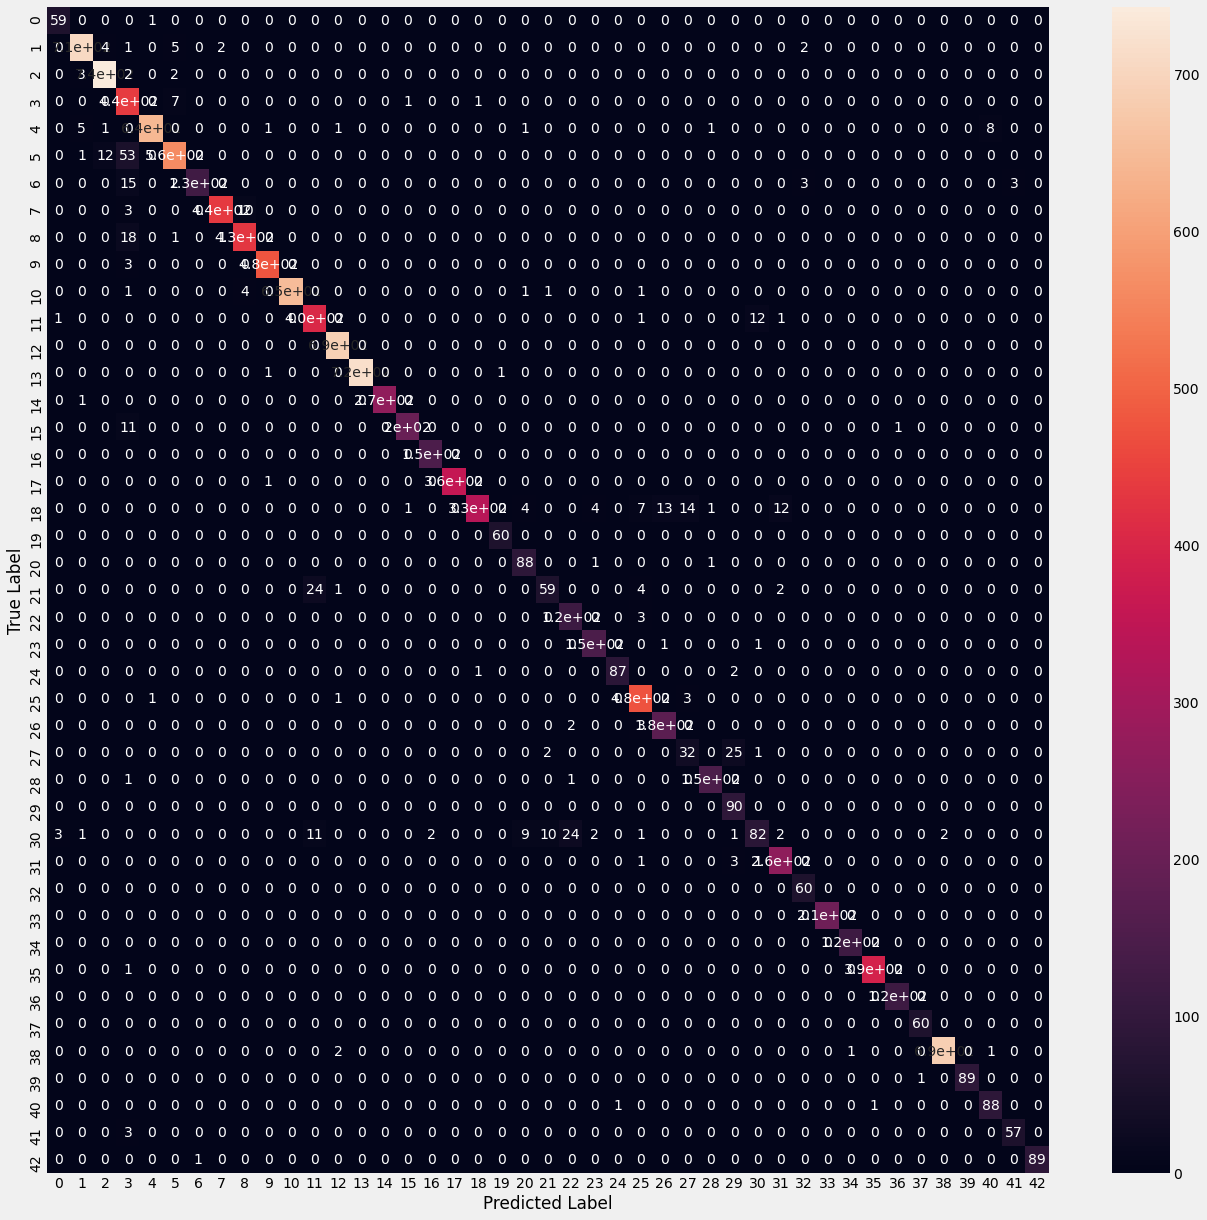

In [27]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

## Classification report

In [28]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        60
           1       0.98      0.98      0.98       720
           2       0.98      0.99      0.98       750
           3       0.80      0.98      0.88       450
           4       1.00      0.97      0.98       660
           5       0.97      0.90      0.93       630
           6       0.99      0.85      0.91       150
           7       0.99      0.97      0.98       450
           8       0.97      0.96      0.96       450
           9       0.99      0.99      0.99       480
          10       1.00      0.99      0.99       660
          11       0.92      0.96      0.94       420
          12       0.99      1.00      1.00       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.99      0.94      0.97       210
          16       0.99      1.00      0.99       150
          17       1.00    

## Predictions on Test Data

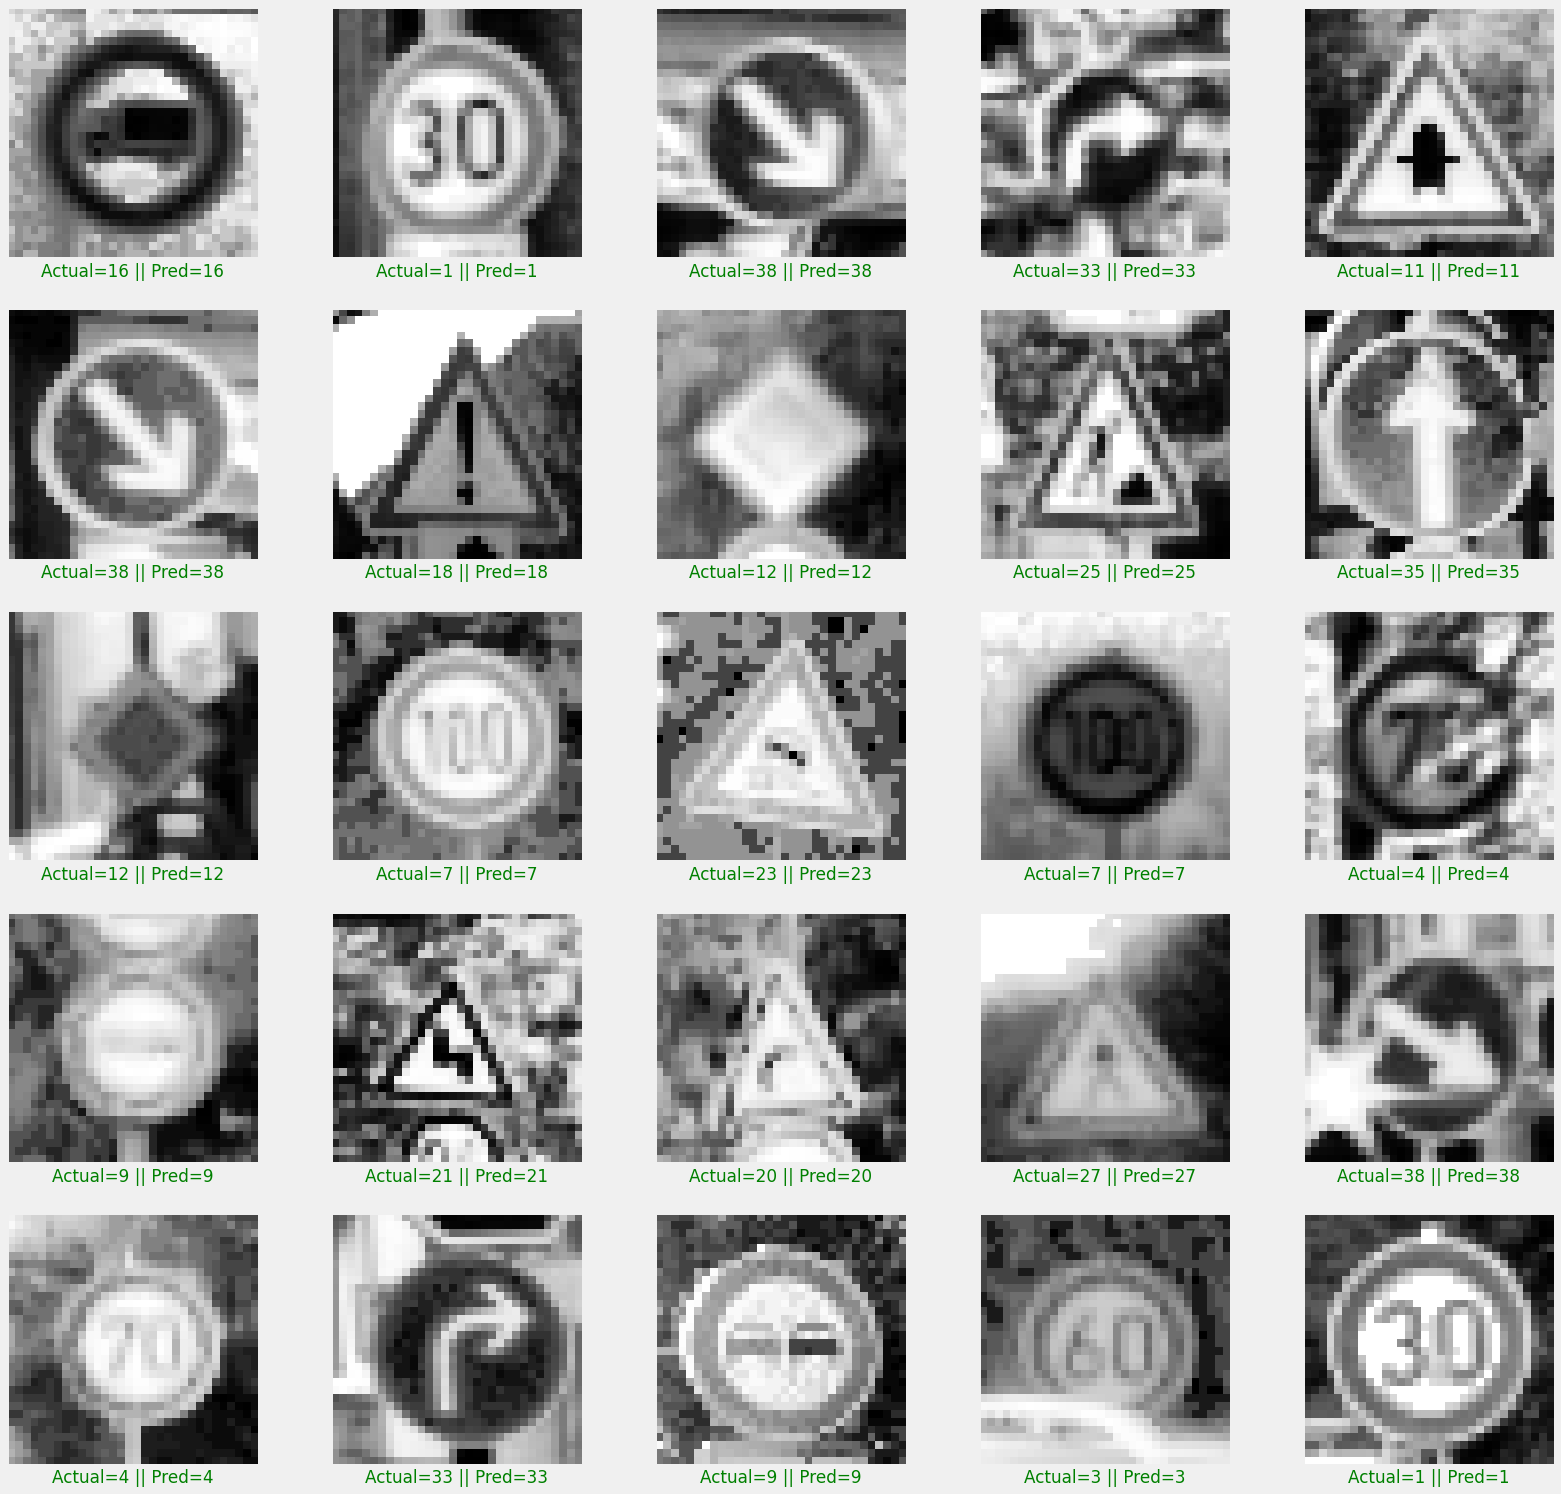

In [29]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i].reshape(IMG_HEIGHT,IMG_WIDTH), cmap='gray')
plt.show()